# Phân loại bình luận tích cực và tiêu cực trên các quán ăn

In [2]:
import pandas as pd
import string
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [3]:
df = pd.read_csv('data_1.csv')
df['Label'] = df['Point'].apply(lambda point: 0 if point >= 5 else 1)
sentences = df['Review'].tolist()
joined_sentences = " ".join(sentences)

## Khai phá dữ liệu

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181 entries, 0 to 1180
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  1181 non-null   object 
 1   Point   1181 non-null   float64
 2   Label   1181 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 27.8+ KB


In [5]:
df.describe()

,Point,Label
count,1181.000000,1181.000000
mean,7.174259,0.126164
std,1.986535,0.332175
min,1.000000,0.000000
25%,6.800000,0.000000
50%,7.600000,0.000000
75%,8.200000,0.000000
max,10.000000,1.000000


In [6]:
df

,Review,Point,Label
0,"Cháo ếch đậm đà, cơm thì không đặc sắc mấy. \r...",7.4,0
1,Quán này mình cũng hay order lắm. Menu quán cũ...,7.8,0
2,Cháo thịt bò 30k\r\n------\r\nĐang mệt người v...,8.0,0
3,"Shinshu đã chuyển qua nguỹen hoàng, vị trí cũn...",8.0,0
4,"Chất lượng : Menu đa dạng , nhiều lựa chọn , t...",8.2,0
...,...,...,...
1176,Đi mua đồ ở gần chợ tam giác nên tiện ghé vào ...,7.4,0
1177,"Trời nóng, mấy mẹ con đi dạo rồi ghé vào ăn ch...",8.0,0
1178,Mình thấy quán này cũng bình thường...chắc mìn...,5.0,0
1179,Quán này cũng rất nổi tiếng. \r\nNhiều chi nhá...,8.2,0


[Text(0.5, 1.0, 'Số lượng mẫu')]

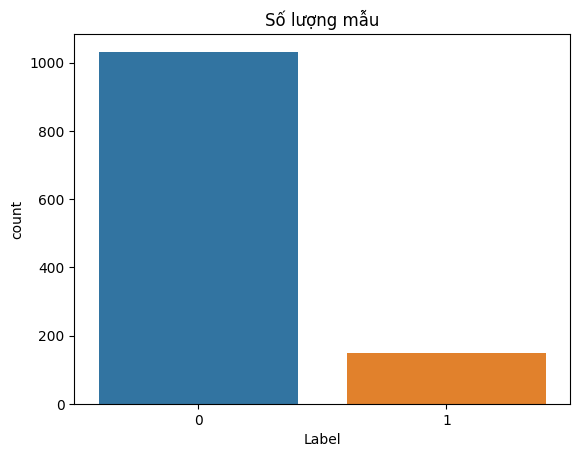

In [7]:
sns.countplot(data=df, x='Label').set(title='Số lượng mẫu')

### WordCloud trước khi tiền xử lý

- <i>WordCloud của tất cả các review</i>

In [8]:
def plot_wordcloud(sentences):
    plt.figure(figsize=(20, 20))
    wordcloud = WordCloud(max_words=200, background_color='white').generate(sentences)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

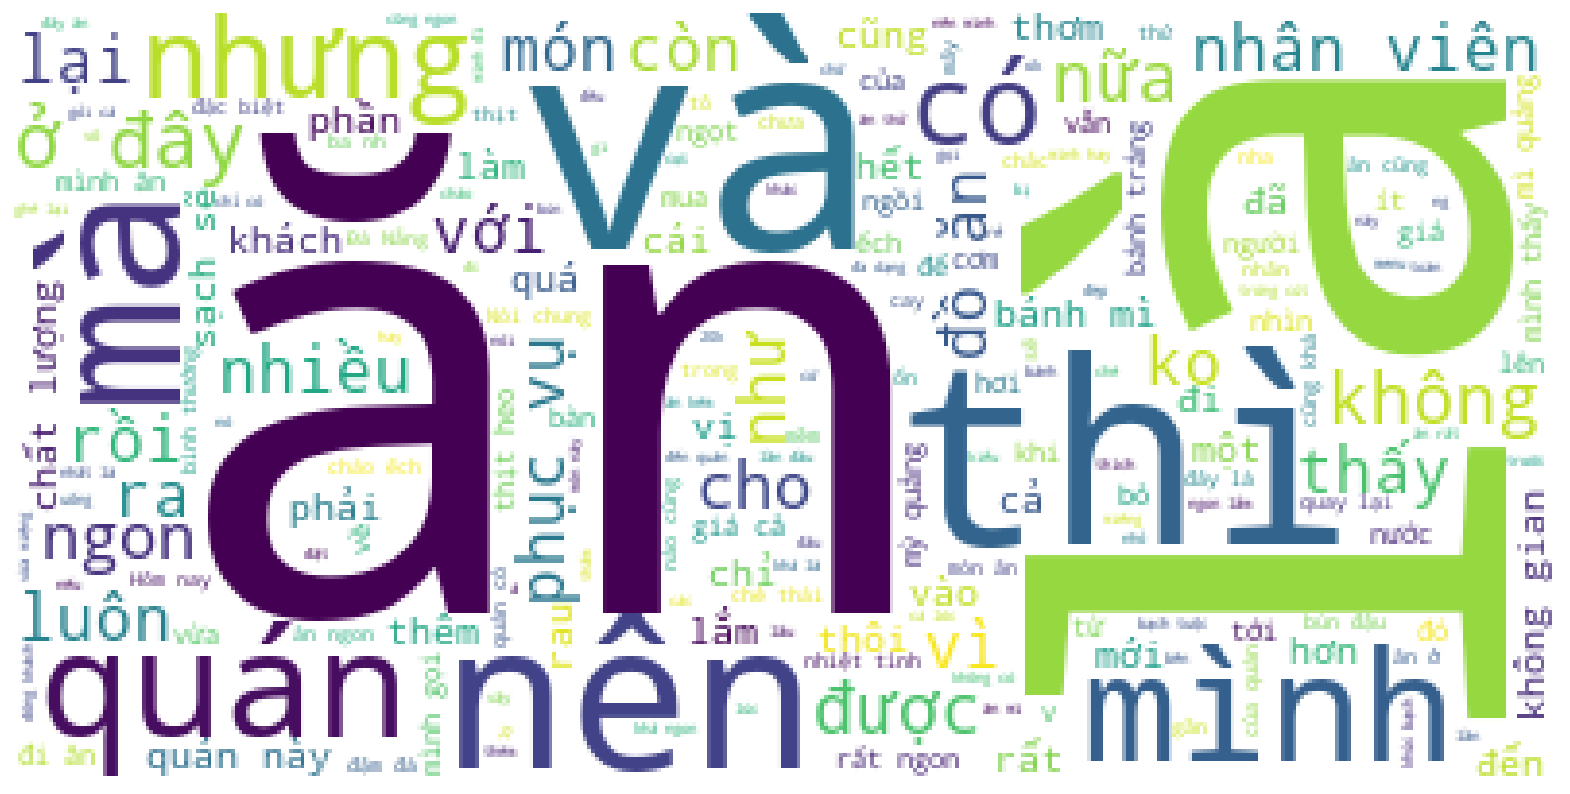

In [9]:
plot_wordcloud(joined_sentences)

In [10]:
negative = df[df['Label'] == 1]
positive = df[df["Label"] == 0]

negative_sentences = " ".join(negative['Review'].tolist())
positive_sentences = " ".join(positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

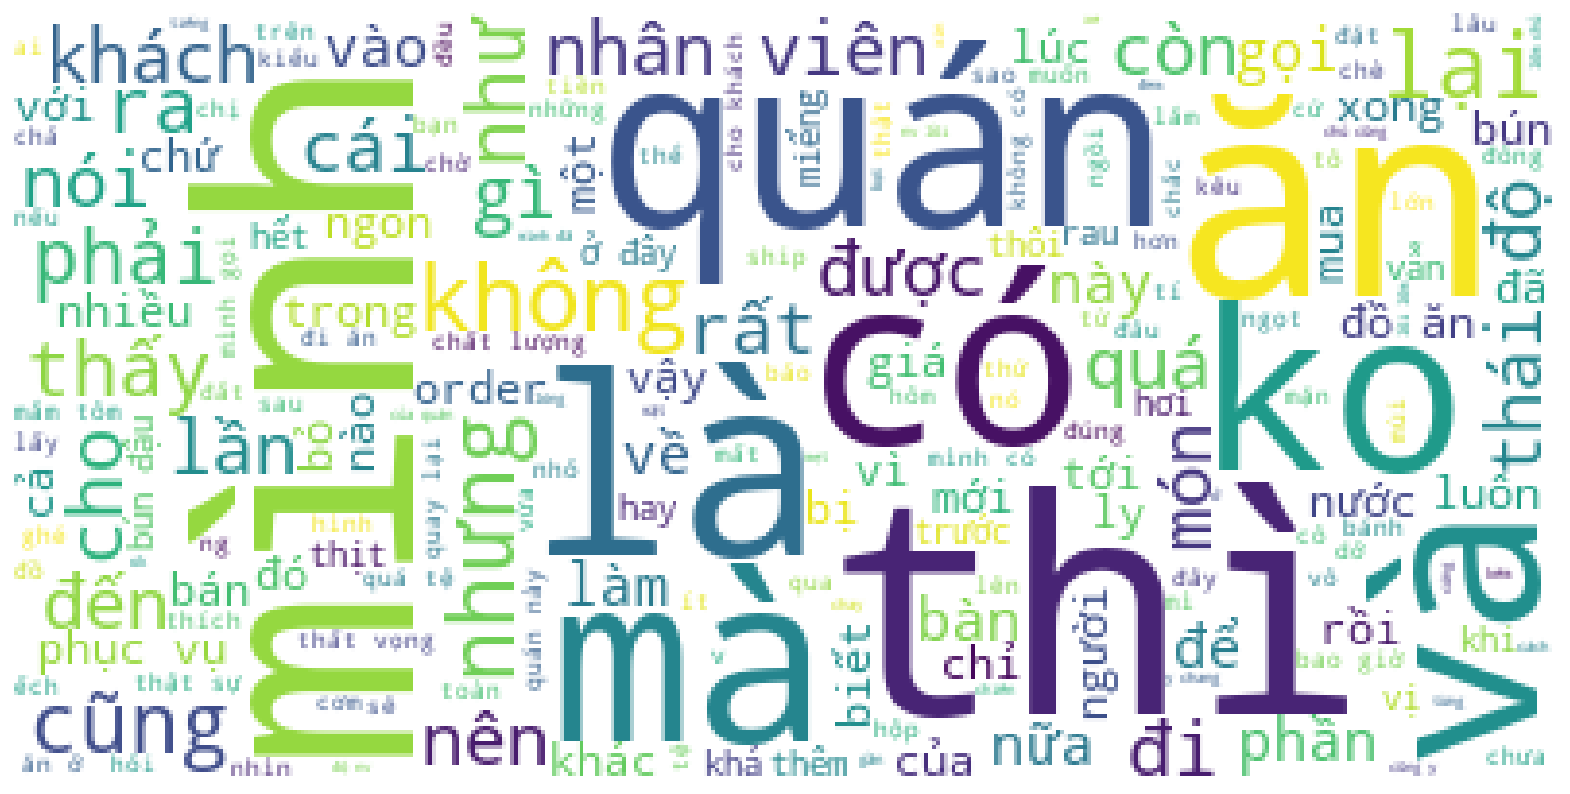

In [11]:
plot_wordcloud(negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

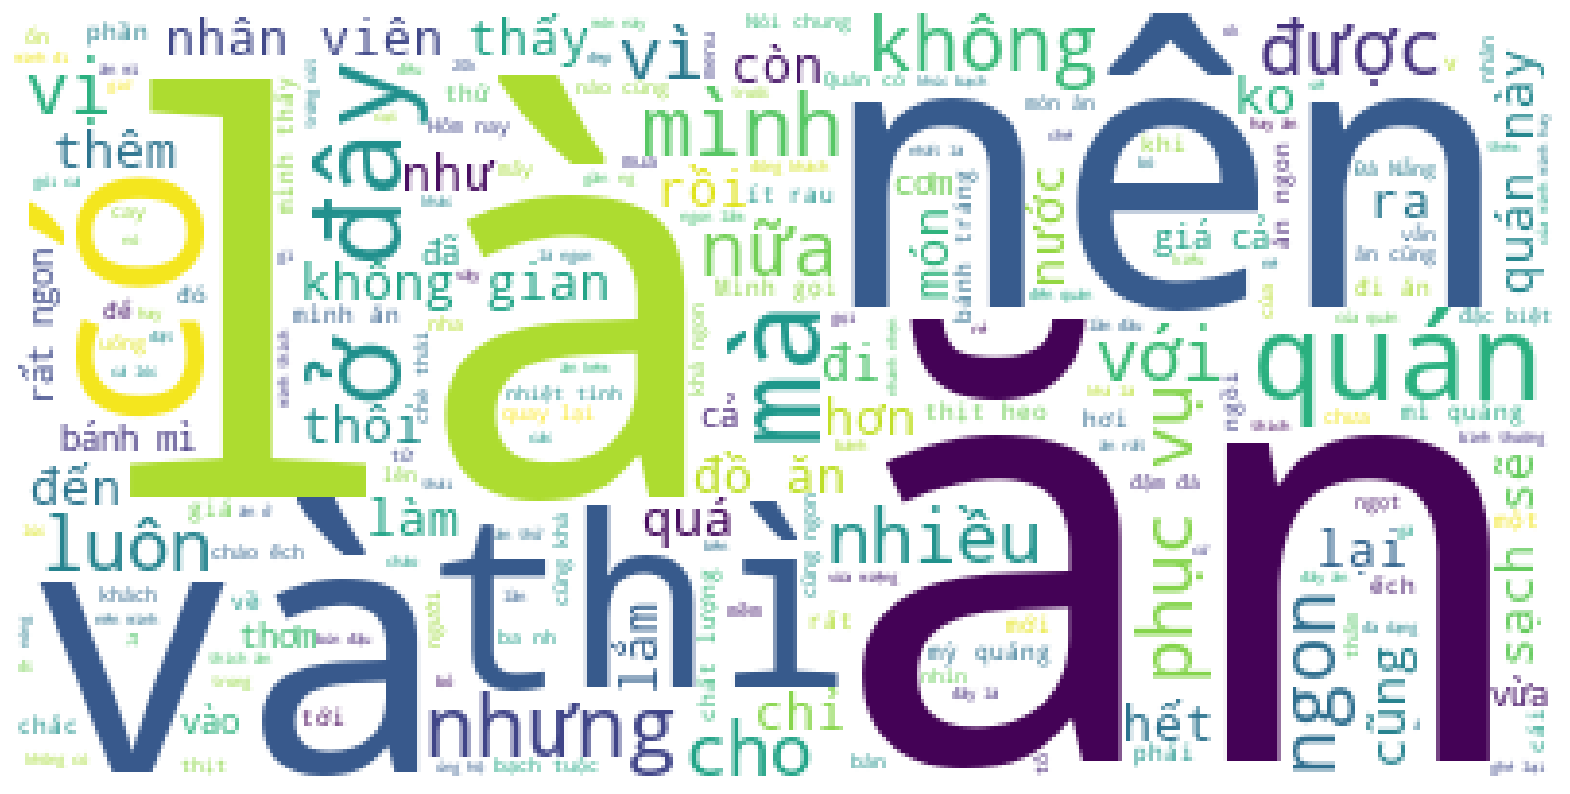

In [12]:
plot_wordcloud(positive_sentences)

### WordCloud sau khi tiền xử lý

Hàm tiền xử lý chuỗi

In [13]:
def tokenize_vietnamese_text(text):
    tokens = ViTokenizer.tokenize(text)
    return tokens


def get_stopwords(url):
    with open(url, 'r+', encoding='utf8') as file:
        stopwords = file.readlines()
        return set(stopwords)
    
    
stopwords = get_stopwords('vietnamese_stopwords_dash.txt')
def review_cleaning(message):
    # chuyển hết chuỗi sang chữ thường
    message = message.lower()
    
    # xoá các kí tự đặc biệt
    removed_punc_str = [char for char in message if char not in string.punctuation]
    removed_punc_str = ''.join(removed_punc_str)

    # tách các từ ghép
    removed_punc_str = tokenize_vietnamese_text(removed_punc_str)

    # xoá các stopwords
    clean_removed_punc_str = [word for word in removed_punc_str.split() if word.lower() not in stopwords]
    return clean_removed_punc_str

In [14]:
def list_to_str(message):
    return " ".join(message)

In [15]:
clean_df = pd.DataFrame(df['Review'].apply(review_cleaning))
clean_df['Review'] = clean_df['Review'].apply(list_to_str)
clean_df['Label'] = df['Label']

clean_sentences = " ".join(clean_df['Review'].tolist())

In [16]:
print(clean_df['Review'])

0       cháo ếch đậm_đà cơm thì không đặc_sắc mấy chủ ...
1       quán này mình cũng hay order lắm menu quán cũn...
2       cháo thịt bò 30k đang mệt người vì thời_tiết đ...
3       shinshu đã chuyển qua nguỹen hoàng vị_trí cũng...
4       chất_lượng menu đa_dạng nhiều lựa_chọn từ hươn...
                              ...                        
1176    đi mua đồ ở gần chợ tam_giác nên tiện ghé vào ...
1177    trời nóng mấy mẹ con đi dạo rồi ghé vào ăn chè...
1178    mình thấy quán này cũng bình thườngchắc mình k...
1179    quán này cũng rất nổi_tiếng nhiều chi_nhánh từ...
1180    có dịp vào đà_nẵng không_thể không ghé vào ăn ...
Name: Review, Length: 1181, dtype: object


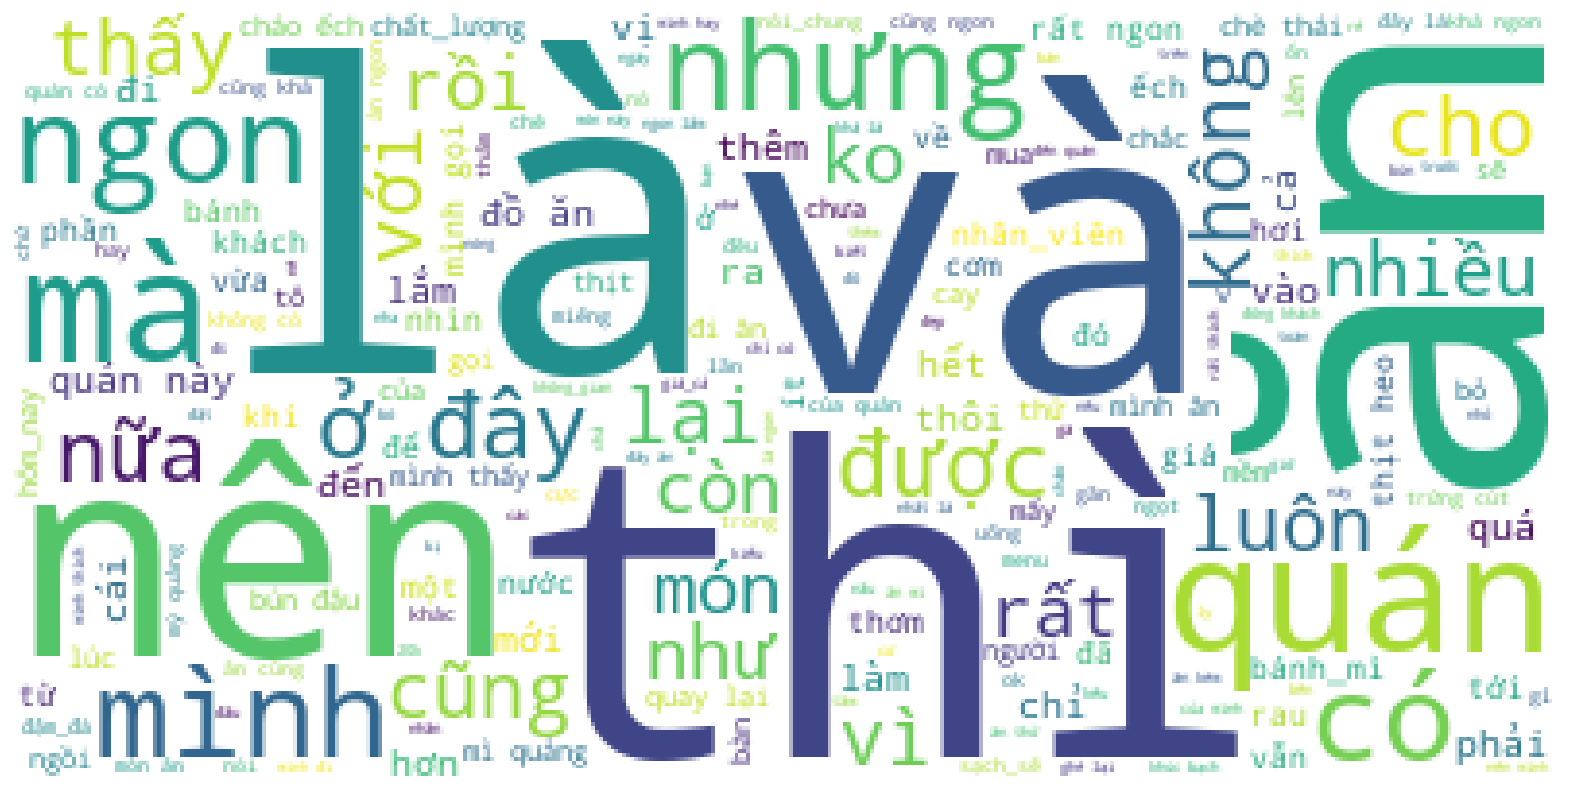

In [17]:
plot_wordcloud(clean_sentences)

In [18]:
clean_negative = clean_df[clean_df['Label'] == 1]
clean_positive = clean_df[clean_df['Label'] == 0]

clean_negative_sentences = " ".join(clean_negative['Review'].tolist())
clean_positive_sentences = " ".join(clean_positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

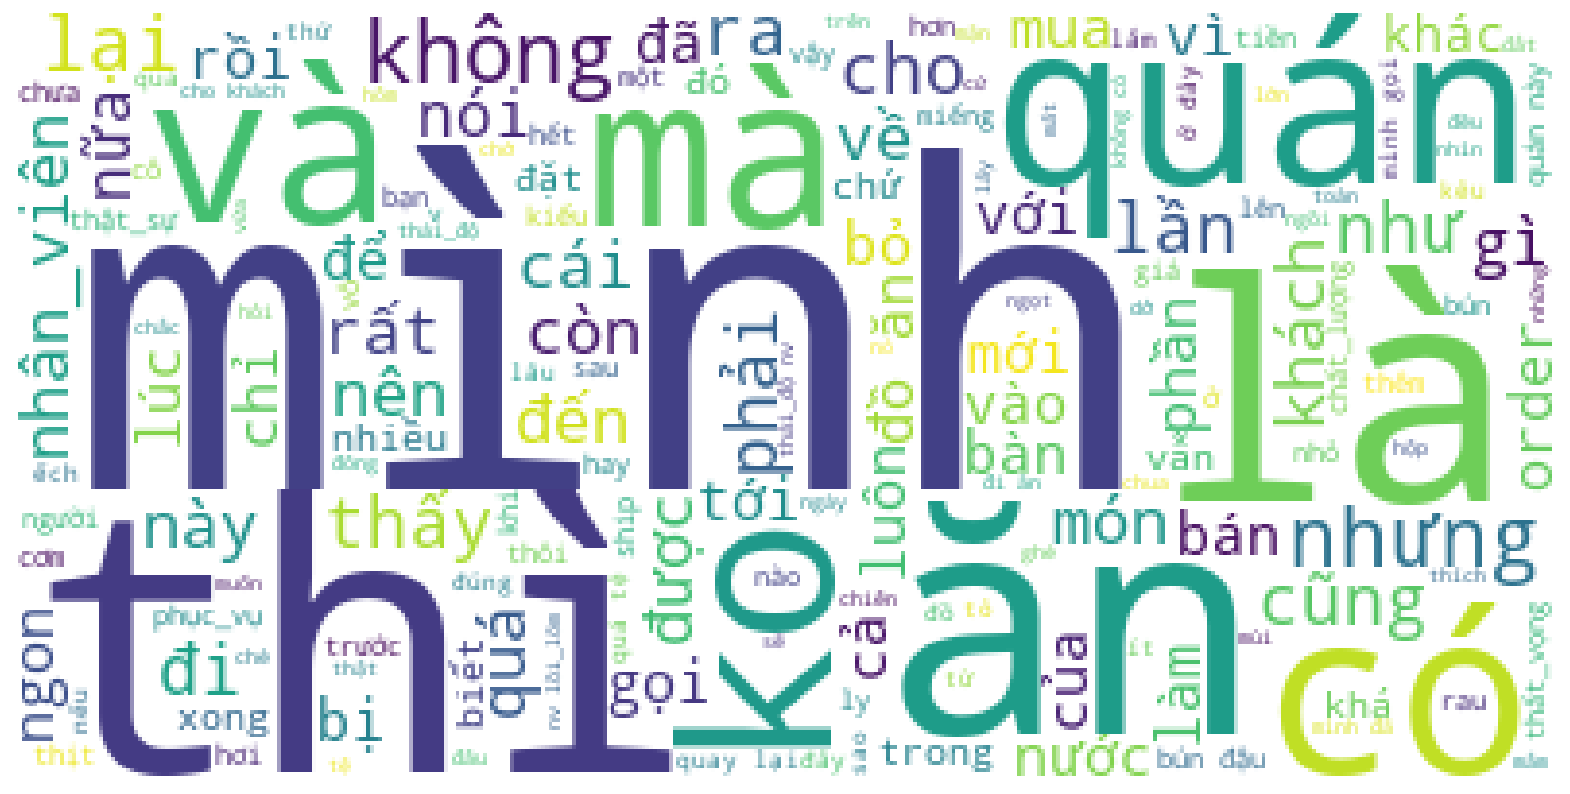

In [19]:
plot_wordcloud(clean_negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

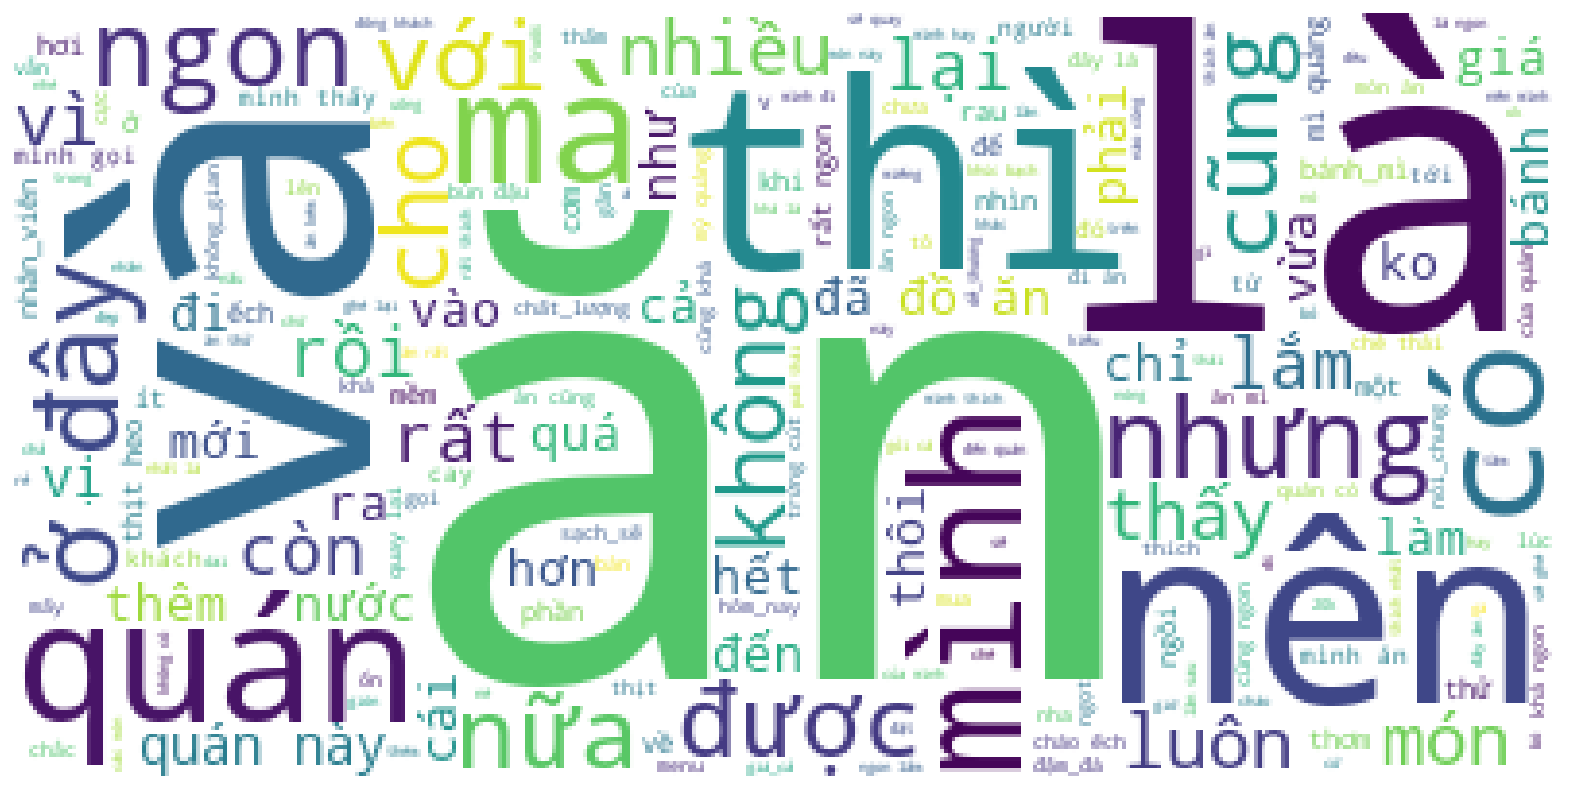

In [20]:
plot_wordcloud(clean_positive_sentences)

## Vector hoá văn bản và trực quan hoá dữ liệu

### CountVectorizer

<i>Áp dụng countvectorizer để vector hoá văn bản</i>
<br>
- Count_matrix có số chiều là 4822 (bằng với số từ vựng của tập dữ liệu vào)
- Count_matrix có số hàng là 1181 (bằng với số tập mẫu văn bản)

In [21]:
# Áp dụng vector
vectorizer = CountVectorizer(analyzer=review_cleaning)
count_matrix = vectorizer.fit_transform(df['Review'])
count_matrix

<1181x4822 sparse matrix of type '<class 'numpy.int64'>'
	with 61416 stored elements in Compressed Sparse Row format>

<i>Áp dụng t-SNE giảm chiều dữ liệu để trực quán hoá lên đồ thị 3 chiều</i>

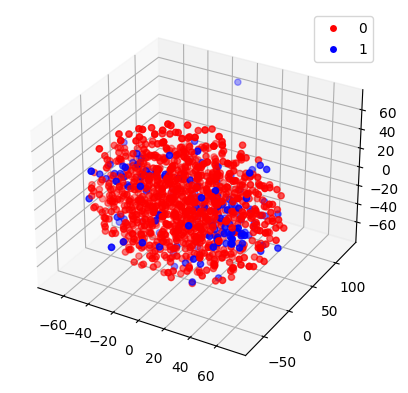

In [22]:
tsne = TSNE(n_components=3, random_state=42)
count_matrix_3d = tsne.fit_transform(count_matrix.toarray())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualize the data in 3D with colors based on the 'label' column
scatter = ax.scatter(count_matrix_3d[:, 0], count_matrix_3d[:, 1], count_matrix_3d[:, 2], c=df['Label'].map({0: 'red', 1: 'blue'}))

# Tạo legend cho nhãn
legend_labels = [0, 1]
legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=label) for label, color in zip(legend_labels, ['red', 'blue'])]
ax.legend(handles=legend_handles, labels=legend_labels)

plt.show()

### TfidfVectorizer

<i>Áp dụng tfidfvectorizer để vector hoá văn bản</i>
<br>
- count_matrix có số chiều là 4822 (bằng với số từ vựng của tập dữ liệu vào)
- count_matrix có số hàng là 1181 (bằng với số tập mẫu văn bản)

In [23]:
# Create a CountVectorizer object and apply it to the 'review' column
vectorizer = TfidfVectorizer(analyzer=review_cleaning)
count_matrix = vectorizer.fit_transform(df['Review'])
count_matrix

<1181x4822 sparse matrix of type '<class 'numpy.float64'>'
	with 61416 stored elements in Compressed Sparse Row format>

<i>Áp dụng t-SNE giảm chiều dữ liệu để trực quán hoá lên đồ thị 3 chiều</i>

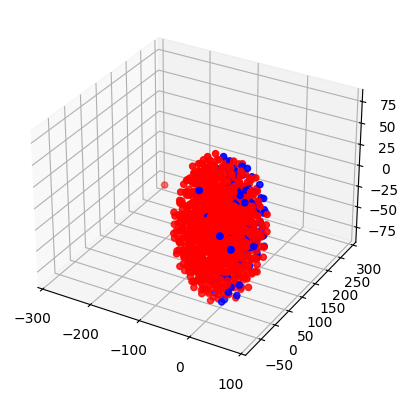

In [40]:
tsne = TSNE(n_components=3,random_state=42)
count_matrix_3d = tsne.fit_transform(count_matrix.toarray())
fig  = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
scatter = ax.scatter(count_matrix_3d[:,0], count_matrix_3d[:,1], count_matrix_3d[:,2],c=df['Label'].map({0: 'red', 1: 'blue'}))


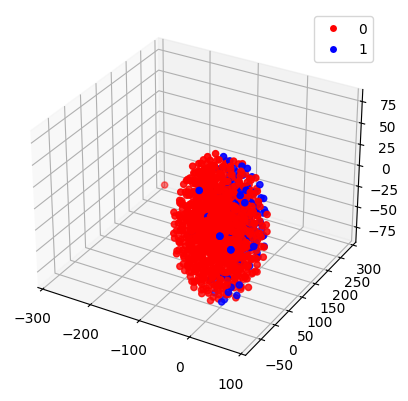

In [25]:

tsne = TSNE(n_components=3, random_state=42)
count_matrix_3d = tsne.fit_transform(count_matrix.toarray())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(count_matrix_3d[:, 0], count_matrix_3d[:, 1], count_matrix_3d[:, 2], c=df['Label'].map({0: 'red', 1: 'blue'}))

# Tạo legend cho nhãn
legend_labels = [0, 1]
legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=label) for label, color in zip(legend_labels, ['red', 'blue'])]
ax.legend(handles=legend_handles, labels=legend_labels)

plt.show()

## Huấn luyện mô hình

In [26]:
def plot_confusion_matrix(x_test, y_test, model:GridSearchCV):
    # Dự đoán tập test
    y_pred = model.predict(x_test)

    # plot ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    print(classification_report(y_test, y_pred))


def train_model(vectorizer, classifier, x, y, cv=5):
    # Tạo pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # cross_validate để dự đoán độ chính xác khi train
    y_pred = cross_val_predict(pipeline, x, y, cv=cv)
    accu = accuracy_score(y, y_pred)
    print('Accuracy score: {}'.format(accu))
    # cm = confusion_matrix(y, y_pred)
    # sns.heatmap(cm, annot=True, fmt='d')
    # print(classification_report(y, y_pred))
    return pipeline.fit(x, y)


def train_model_with_hyperparameters(vectorizer, classifier, x, y, cv=5):
    # Tạo pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # Kiểm tra mô hình chọn để lựa chọn đúng bộ siêu tham số
    if isinstance(classifier, MultinomialNB):
        para_grid = {
            'classifier__alpha': [0.1, 0.5, 1.0],
            'classifier__fit_prior': [True, False]
        }

    # thêm hyperparameters sau tuỳ theo mô hình lựa chọn
    else:
        para_grid = {
            'classifier__alpha': [0.1, 0.5, 1.0],
            'classifier__fit_prior': [True, False]
        }


    # Tìm kiếm bộ tham số tối ưu cho mô hình
    grid_search = GridSearchCV(pipeline, param_grid=para_grid, scoring='accuracy', cv=cv)

    search_result = grid_search.fit(x, y)
    result = pd.DataFrame(search_result.cv_results_, columns=['rank_test_score', 'mean_test_score', 'param_classifier__alpha','param_classifier__fit_prior']).sort_values(by='rank_test_score')
    print("Best score: {} with hyperparameters {}".format(search_result.best_score_, search_result.best_params_))

    # Trả về kết quả, lần lượt và mô hình đã train và kết quả khi train với từng bộ tham số
    return search_result, result

### Mô hình Naive Bayes

#### CountVectorizer làm input

In [27]:
x = df['Review']
y = df['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

##### Không dùng hyperparameters

In [28]:
train_model(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.9116222760290557


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x0000028D02461E10>)),
                ('classifier', MultinomialNB())])

##### Có dùng hyperparameters

In [29]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.9261482292807595 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': True}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
0,1,0.926148,0.1,True
3,2,0.923724,0.5,False
1,3,0.921307,0.1,False
2,4,0.917678,0.5,True
4,5,0.911632,1.0,True


<b><i>Nhận xét</i></b>: Bằng cách lựa chọn siêu tham số thì độ chính xác của thuật toán tăng 1,45%, từ 91,16 lên 92,61% 

##### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       310
           1       0.76      0.71      0.74        45

    accuracy                           0.94       355
   macro avg       0.86      0.84      0.85       355
weighted avg       0.93      0.94      0.93       355



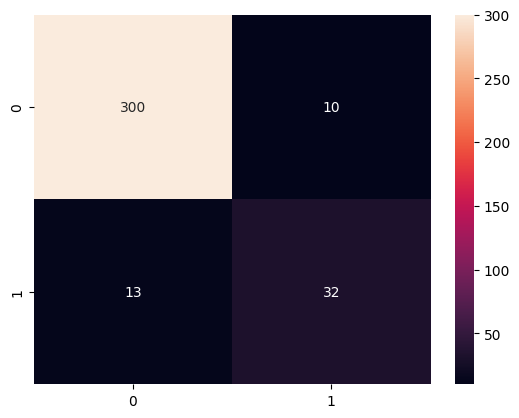

In [30]:
plot_confusion_matrix(x_test, y_test, model)

#### TfidfVectorizer làm input

##### Không dùng hyperparameters

In [31]:
# Label 1 có tỉ lệ chính xác bằng 0 vì do mất cân bằng giữa các label trong dataset
# Tính chất của TF-IDF nếu tỉ lệ các label bị mất cân bằng thì dễ xảy ra tình trang dự đoán thiên vị
temp = pd.concat([df[df['Label'] == 0].loc[:200], df[df['Label'] == 1]])
x_temp = temp['Review']
y_temp = temp['Label']


In [32]:
train_model(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.87409200968523


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x0000028D02461E10>)),
                ('classifier', MultinomialNB())])

##### Có dùng hyperparameters

In [33]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.9176852866009492 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
1,1,0.917685,0.1,False
0,2,0.884987,0.1,True
3,3,0.881358,0.5,False
2,4,0.874093,0.5,True
4,4,0.874093,1.0,True


##### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       310
           1       0.80      0.62      0.70        45

    accuracy                           0.93       355
   macro avg       0.87      0.80      0.83       355
weighted avg       0.93      0.93      0.93       355



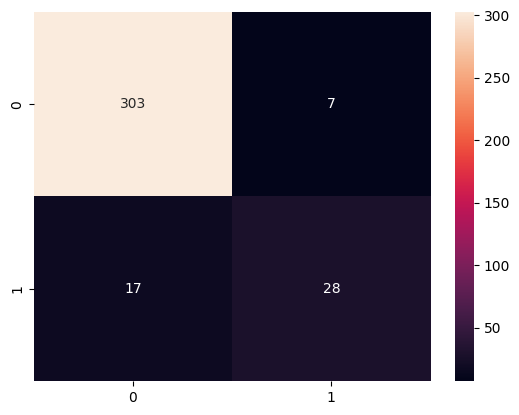

In [34]:
plot_confusion_matrix(x_test, y_test, model)

### Mô hình Support Vector Machine

#### CountVectorizer làm input

#### TfidfVectorizer làm input